In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

In [15]:
normal = r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal'
pneumonia = r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia'

In [16]:
dirlist=[normal, pneumonia]
classes=['normal', 'pneumonia']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  538    labels:  538


In [17]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(538,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,normal
1,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,normal
2,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,normal
3,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,normal
4,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,normal


In [18]:
print(df['labels'].value_counts())

normal       425
pneumonia    113
Name: labels, dtype: int64


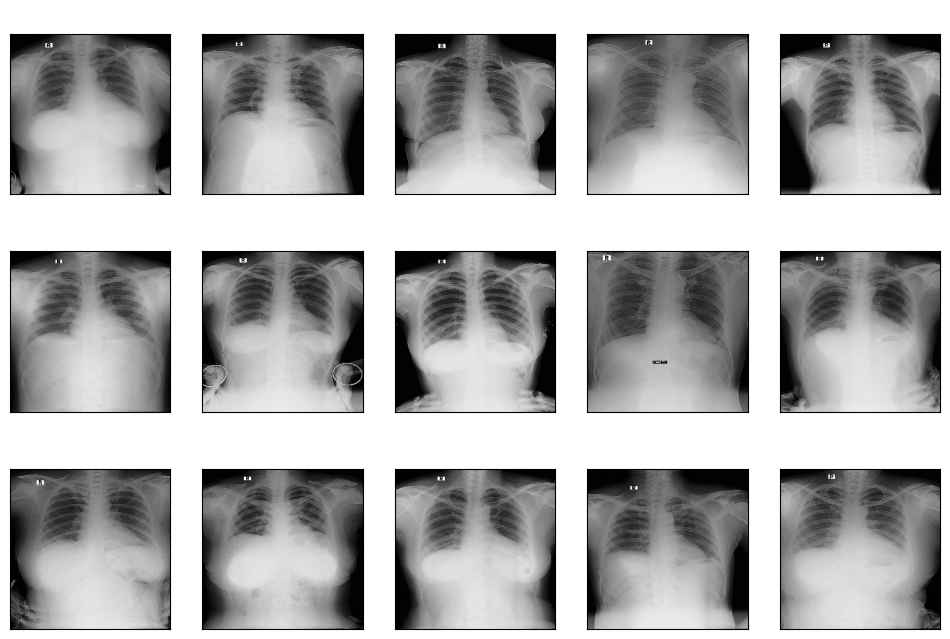

In [19]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (459, 2)
test set shape: (27, 2)
validation set shape: (52, 2)


In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [22]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 32, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 32, shuffle = False)

Found 459 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.
Found 27 validated image filenames belonging to 2 classes.


In [23]:
train_gen.class_indices

{'normal': 0, 'pneumonia': 1}

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', input_shape=(128, 128, 3), include_top=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_298 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [26]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 30, verbose = 1)

Epoch 1/30
29/29 [==============================] - 53s 1s/step - loss: 0.7772 - accuracy: 0.6231 - val_loss: 1484.4857 - val_accuracy: 0.1538
Epoch 2/30
29/29 [==============================] - 37s 1s/step - loss: 0.6082 - accuracy: 0.6993 - val_loss: 62.2492 - val_accuracy: 0.8462
Epoch 3/30
29/29 [==============================] - 37s 1s/step - loss: 0.5873 - accuracy: 0.7625 - val_loss: 0.8018 - val_accuracy: 0.7115
Epoch 4/30
29/29 [==============================] - 37s 1s/step - loss: 0.5270 - accuracy: 0.7734 - val_loss: 179.5950 - val_accuracy: 0.3846
Epoch 5/30
29/29 [==============================] - 37s 1s/step - loss: 0.5251 - accuracy: 0.7669 - val_loss: 2.7239 - val_accuracy: 0.7308
Epoch 6/30
29/29 [==============================] - 38s 1s/step - loss: 0.5008 - accuracy: 0.7778 - val_loss: 1.2922 - val_accuracy: 0.7692
Epoch 7/30
29/29 [==============================] - 36s 1s/step - loss: 0.5088 - accuracy: 0.7712 - val_loss: 0.5353 - val_accuracy: 0.8462
Epoch 8/30
29/

KeyboardInterrupt: 